In [110]:
from collections import defaultdict
from itertools import groupby
import operator
import os
import re

import hdbscan
import numpy as np
import pandas as pd
import pickle
import random
import sparse
#import tensorly as tl
#import tensorly.decomposition as decomp
import sktensor
import umap
import urllib3
#import wget

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import logging
logging.basicConfig(level=logging.DEBUG, 
                    format='%(msecs)d %(levelname)-8s [%(lineno)d] %(message)s')

if not os.path.exists('cp_orth.py'):
    wget.download('http://web.stanford.edu/~vsharan/cp_orth.py')
from cp_orth import orth_als

30 DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


|cutoff|         shape         | d=2  | d=4  | d=5 | d=6 | d=7 | d=10|
|------|-----------------------|------|------|-----|-----|-----|-----|
|     1| 383 k, 110 k, 200 k   |      
|     2| 186 k,  60 k,  99 k   |
|     5|  97 k,  33 k,  50 k   |
|    10|  64 k,  23 k,  32 k   |
|    16|  49 k,  19 k,  24 k   |
|    32|  32 708 13 951 15 740 |14 min|
|    64|  21 033 10 294  9 874 | 6 min|
|   128|  13 093  7 345  6 116 | 2 min|
|------|-----------------------|------|------|-----|-----|-----|-----|
|   256|   7 957  5 054  3 740 | 2 min|
|   512|   4 598  3 269  2 183 | 1 min|
|  1024|   2 489  2 084  1 196 |  51 s|
|  2048|   1 251  1 293    579 |  27 s| 2 min|14 min|  
|  4096|     622    773    243 |  12 s| 1 min| 2 min|  m  |   s|15 min|
|  8192|     278    414    101 |     s|  55 s| 1 min|1 min|   s|4  min|
| 16384|      87    185     43 |     s|     s|  17 s| 29 s| 27s| 50 s |

10-es gyakorisági cutoffal a ginnyn még lefut, 5-össel már nem.

In [11]:
ktensor, fit, n_iterations, exectimes = pickle.load(open(
    '/mnt/store/home/makrai/project/verb-tensor/exper/sktensor/decomp_32_4.pkl', mode='rb'))

In [29]:
def visu(metric='euclidean'):
    mapping = umap.UMAP(n_components=2, metric=metric)
    logging.info('UMAP...')
    embed2 = mapping.fit_transform(ktensor.U[1])
    logging.info('HDBScan...')
    plt.scatter(*embed2.T, s=1)
    return embed2

829 DEBUG    [2515] update_title_pos
861 DEBUG    [2515] update_title_pos
916 DEBUG    [2515] update_title_pos
970 DEBUG    [2515] update_title_pos
997 DEBUG    [2515] update_title_pos


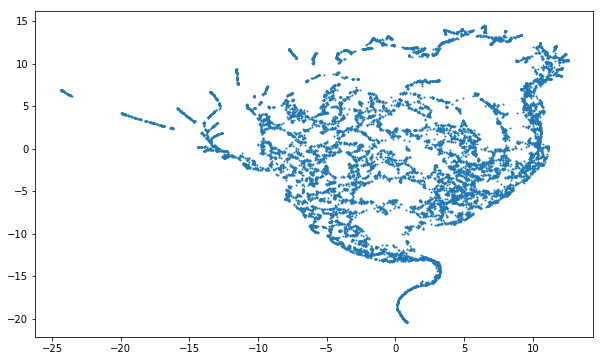

In [19]:
visu()

`metric='cosine'` and `'correlation'` exceed recursion limit

In [35]:
clusser = hdbscan.HDBSCAN()#metric=)
# The implementation defaults min_samples to whatever min_cluster_size is set to

In [108]:
labels = clusser.fit_predict(ktensor.U[1])

319 DEBUG    [2515] update_title_pos
456 DEBUG    [2515] update_title_pos
637 DEBUG    [2515] update_title_pos
693 DEBUG    [2515] update_title_pos
724 DEBUG    [2515] update_title_pos


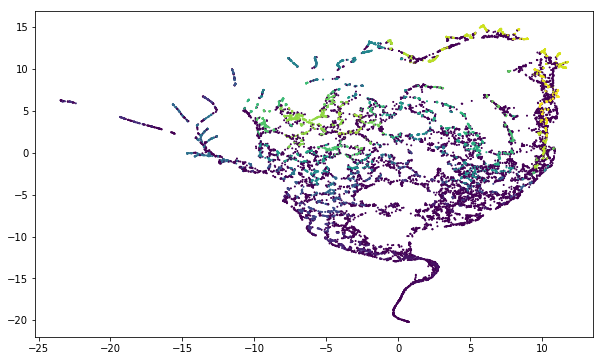

In [39]:
plt.scatter(*embed2.T, c=labels, s=1)

In [145]:
tensor, index = pickle.load(open('/mnt/store/home/makrai/project/verb-tensor/sktensor/tensor_32.pkl', mode='rb'))

In [146]:
list(index[1].items())[:10]

[('NULL', 0),
 ('van', 1),
 ('lesz', 2),
 ('mond', 3),
 ('tud', 4),
 ('tesz', 5),
 ('tart', 6),
 ('lát', 7),
 ('vesz', 8),
 ('kerül', 9)]

In [140]:
def show_clustering(
        labels, embed_name=None, preproc=None, n_clust_show=30, 
        print_samples=True, sample_size=5, show_size_of=60, sort_sizes='descending',
        min_size=3, plot='scatter', average=False):
    """
    sort_sizes in ['ascending', 'descending', 'rand']
    """
    clus_len_l = [(key, len(list(group))) for key, group in groupby(sorted(labels))]
    if sort_sizes is not 'rand':
        clus_len_l = sorted(clus_len_l, key=operator.itemgetter(1), reverse=sort_sizes=='descending')
    clusters, lens = zip(*list(clus_len_l))
    n_clusters = len(clus_len_l)
    #entropy_ = stats.entropy(lens)
    header = '{} clusters, entropy={:.2}, sizes: {}{}'.format(
        n_clusters, 'entropy_', ' '.join(map(str, lens[:show_size_of])), 
        '..' if n_clusters>show_size_of else '')
    print(header)
    verbs = np.array(list(index[1].keys()))
    logging.info(verbs[:10])
    for cluster_i, clus_len in zip(clusters[:n_clust_show+1], lens):
        if clus_len < min_size or cluster_i == -1:
            continue
        clus_siz = np.sum(labels==cluster_i)
        print('\n{} verbs. id: {}\n'.format(clus_siz, int(cluster_i)))
        #cluster.sample(n=min(sample_size, clus_siz)
        print(verbs[labels==cluster_i])
    print('\n{}'.format(header))
    return entropy_

In [147]:
show_clustering(labels)

951 INFO     [19] ['NULL' 'van' 'lesz' 'mond' 'tud' 'tesz' 'tart' 'lát' 'vesz' 'kerül']


431 clusters, entropy=en, sizes: 7565 177 84 83 80 70 69 68 68 64 63 62 57 55 53 52 51 50 50 47 45 43 42 40 39 38 37 37 36 36 35 35 34 34 32 32 32 31 31 30 30 29 29 29 29 28 27 26 26 26 25 24 24 24 24 24 23 23 23 23..

177 verbs. id: 358

['indukál' 'rázogat' 'kinevel' 'abbanull' 'elvitatkozik' 'elhalkul'
 'versenyeztet' 'elállít' 'felpofoz' 'elgyengül' 'eltakarodik'
 'elmaradozik' 'hancúroz' 'kimagaslik' 'himbál' 'fecskendez' 'ráerősít'
 'rávetül' 'cammog' 'ficánkol' 'kiöregedik' 'megbántódik' 'csicsereg'
 'pislant' 'elzúg' 'bebeszél' 'csiripel' 'elkoptat' 'átpasszol'
 'leteleped' 'visszanyújt' 'peng' 'kioldódik' 'kaparint' 'föllobban'
 'kivetkőzik' 'vakációz' 'megszurkál' 'egybemosódik' 'hallucinál'
 'elhatol' 'megpuszil' 'hipnotizál' 'visszatelepül' 'megihlet'
 'szétmorzsol' 'tárolódik' 'idehord' 'visszaültet' 'furulyázik' 'bennnull'
 'átutaltat' 'eltöm' 'csonkít' 'kigyőz' 'visszaperel' 'átmelegít'
 'figyelmez' 'szétrág' 'bedönt' 'leszerződik' 'előrefut' 'bejárat'
 'regenerál' 'hajr

NameError: name 'entropy_' is not defined